In [115]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# from urllib import request

# filenames = [
#     "train-images-idx3-ubyte.gz",
#     "train-labels-idx1-ubyte.gz",
#     "t10k-images-idx3-ubyte.gz",
#     "t10k-labels-idx1-ubyte.gz"
# ] # define file names

# # download from aws server to local
# folder = 'data/'
# base_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/"
# for name in filenames:
#     print("Downloading " + name + "...")

#     # lưu vào folder data_fashion_mnist
#     request.urlretrieve(base_url + name, folder + name) # retrieve base url downloading adress and folder name to download

In [43]:
import numpy as np
import gzip # download from zip file from google drive

with gzip.open('data/train-images-idx3-ubyte.gz', 'rb') as f:
    X_train = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28*28)

#? label not need to reshape bc it already 1D array
with gzip.open('data/train-labels-idx1-ubyte.gz', 'rb') as f:
    y_train = np.frombuffer(f.read(), np.uint8, offset=16)

with gzip.open('data/t10k-images-idx3-ubyte.gz', 'rb') as f:
    X_test = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28*28)

#? label not need to reshape bc it already 1D array
with gzip.open('data/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    y_test = np.frombuffer(f.read(), np.uint8, offset=16)


In [44]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(59992,)
(10000, 784)
(9992,)


### Using Pytorch for cleaner download

In [151]:
from torchvision.datasets import FashionMNIST

data_transforms = transforms.Compose([transforms.ToTensor()])
trainset = FashionMNIST(root='data', # define Root Folder that contain the datasets
                        train=True, # specify download training dataset only
                        download=True, transform=data_transforms # convert dtype to Tensor
                    )

testset =  FashionMNIST(root='test', # define Root Folder that contain the datasets
                        train=True, # specify download training dataset only
                        download=True, transform=data_transforms # convert dtype to Tensor
                    )

trainset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [152]:
img, label = trainset[0] # check if a sample contain img & label
print(type(img), label)

<class 'torch.Tensor'> 9


In [157]:
import torch
from torch.utils.data import DataLoader, TensorDataset

count = 0
# Iterate through the dataloader to get one input at a time
for i in range(1):
    img, label = trainset[0] # check if a sample contain img & label
    # inputs will have a shape of [1, 3, 32, 32] (batch size 1)
    # targets will have a shape of [1]
    print(f"Shape of input batch: {img.shape}")
    count += 1
    # You can now pass 'inputs' to your model
    # model(inputs)

print(count)

Shape of input batch: torch.Size([1, 28, 28])
1


**Pytorch/Tensor Format (C, H, W)** - Channel Dimension, Height, Width

**Numpy/Matplotlib Format (H, W, C)** - Height, Width, Channel

-> If download dataset from Pytorch then you have to reshape it back to Numpy format to avoid Conflict in Matrix Multiplication

In [118]:
print(img.shape)
np_img = img.numpy() # (C, H, W) - (0, 1, 2)
np_img = np.transpose(np_img, (1, 2, 0)) # re-arrange by index
print(np_img.shape)

torch.Size([1, 28, 28])
(28, 28, 1)


Convert data back to [0, 255] from [0, 1]
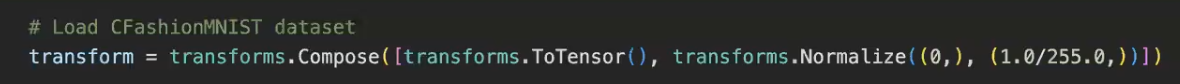

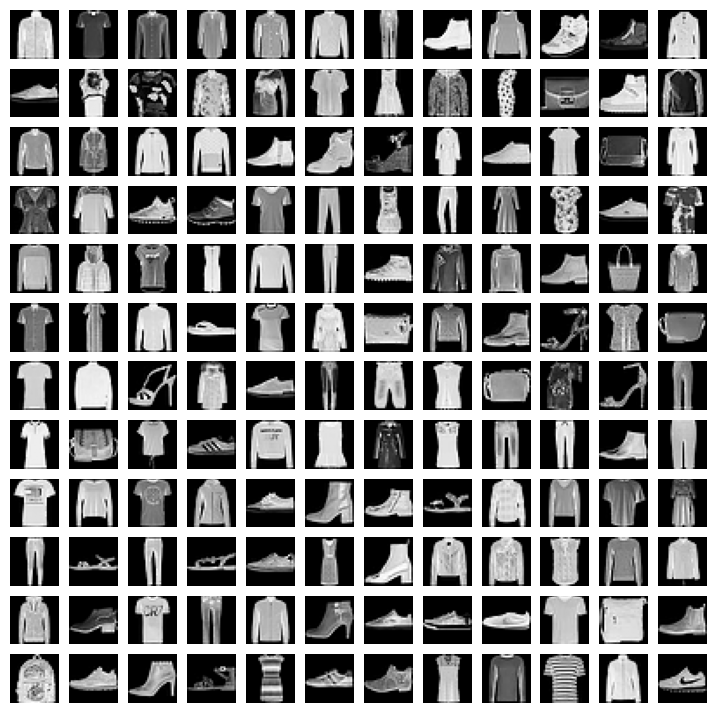

In [120]:

# image indices
indices = np.random.randint(X_train.shape[0], size=144)

fig = plt.figure(figsize=(9, 9))
col = 12
row = 12

for i in range(1, col*row + 1):
    img = X_train[indices[i - 1]].reshape(28, 28)
    fig.add_subplot(row, col, i) # add small plot within the whole plot
    plt.axis('off')
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)

to_tensor() - auto convert Pil image value to [0, 1] tensor value range.
 
crossentropy loss function contain Softmax by default

In [121]:
softmax_regression_model = nn.Sequential(
    nn.Flatten(), # start flatten from 1D to 1D (start_dim=1, end_dim=1)
    nn.Linear(784, 10) # return z, not yhat
)
softmax_regression_model.to(device)
print(softmax_regression_model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)


In [122]:
width = 28
height = 28
images = torch.rand(32, 1, width, height).to(device) # Total Sample, C, H, W. Also convert to CUDA array format
image = images / (width*height) # normalize input data to [0, 1]
z = softmax_regression_model(images)
print(z.shape)

torch.Size([32, 10])


In [133]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(trainset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=1, shuffle=True)

In [ ]:
max_epoch = 10
optimizer = torch.optim.SGD(softmax_regression_model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(max_epoch):
    epoch_loss = 0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        # reset gradient calculation for each batch
        optimizer.zero_grad()

        # Forward pass
        outputs = softmax_regression_model(inputs)
        print(outputs)

        loss = criterion(outputs, labels) # prediction output, target input
        train_losses.append(loss)

        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1) # return max value by C index (dimension index, if 2D then index 2, if 1D then index 1)

        correct = (predicted == labels).sum().item() # {labels: correct_label_count}.item()
        total_train += 1
        correct_train += correct

        loss.backward() # calc Gradient base on defined Loss function
        optimizer.step() # update weight and bias parameters

        

        print(f'Epoch {epoch} - {predicted}')
        break

tensor([[-0.1111, -0.0573,  0.0872, -0.0252,  0.0935,  0.1893, -0.1634,  0.2576,
         -0.3780, -0.1640]], device='cuda:0', grad_fn=<AddmmBackward0>)
Epoch 0 - tensor([7], device='cuda:0')
tensor([[-0.5613, -0.1016, -0.0385, -0.2919,  0.0026,  0.1060, -0.2055, -0.3203,
         -0.5089,  1.2372]], device='cuda:0', grad_fn=<AddmmBackward0>)
Epoch 1 - tensor([9], device='cuda:0')
tensor([[-0.3985, -0.0917, -0.4052, -0.1485, -0.1197, -0.3790,  0.1009, -0.0231,
         -0.3415,  0.6878]], device='cuda:0', grad_fn=<AddmmBackward0>)
Epoch 2 - tensor([9], device='cuda:0')
tensor([[-0.9628, -0.1778, -0.8590, -0.7779, -0.5374, -0.4981, -0.8717, -0.8063,
         -1.0638,  5.7911]], device='cuda:0', grad_fn=<AddmmBackward0>)
Epoch 3 - tensor([9], device='cuda:0')
tensor([[-0.6015,  1.0030, -0.7232, -0.5973, -0.5746, -0.4520,  0.0414, -0.2238,
         -0.5880,  2.5282]], device='cuda:0', grad_fn=<AddmmBackward0>)
Epoch 4 - tensor([9], device='cuda:0')
tensor([[ 0.4416,  1.8808, -1.3524, -1.2